In [6]:
!pip install tensorflow streamlit scikit-learn seaborn matplotlib

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st

In [7]:

import zipfile
import os


# Assuming your zip file is located at '/content/Teeth DataSet.zip'
zip_file_path = '/content/Teeth DataSet.zip'
extract_to_dir = '/content'  # You can change the extraction directory if needed

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)



In [8]:
extracted_folders = [f for f in os.listdir(extract_to_dir) if os.path.isdir(os.path.join(extract_to_dir, f))]
for folder_name in extracted_folders:
    folder_path = os.path.join(extract_to_dir, folder_name)
    if all(os.path.exists(os.path.join(folder_path, subfolder)) for subfolder in ['Training', 'Validation', 'Testing']):
        extracted_folder_name = folder_name
        break
else:
    raise FileNotFoundError("Could not find extracted folder with 'Training', 'Validation', and 'Testing' subfolders.")


In [9]:
main_dir = os.path.join(extract_to_dir, extracted_folder_name)
train_dir = os.path.join(main_dir, 'Training')
val_dir = os.path.join(main_dir, 'Validation')
test_dir = os.path.join(main_dir, 'Testing')


In [10]:
print(f"Training Directory: {train_dir}")
print(f"Validation Directory: {val_dir}")
print(f"Testing Directory: {test_dir}")


Training Directory: /content/Teeth_Dataset/Training
Validation Directory: /content/Teeth_Dataset/Validation
Testing Directory: /content/Teeth_Dataset/Testing


In [11]:
train_datagen = ImageDataGenerator(rescale=1/255., rotation_range=25, width_shift_range=0.1,
                                   height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, brightness_range=[0.5, 1.0], channel_shift_range=0.05)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=4, class_mode='categorical')
val_generator = test_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=4, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=4, class_mode='categorical')


Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1508 images belonging to 10 classes.


In [12]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Unfreeze layers

model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
])

In [15]:

num_classes = len(train_generator.class_indices)

if len(test_generator.class_indices) != num_classes:
    print("Warning: Number of classes in test_generator is different from training data.")
    print("Adjusting the model's output layer...")

    model.layers[-1] = keras.layers.Dense(num_classes, activation='softmax')

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print("Model output layer adjusted.")

train_classes = list(train_generator.class_indices.keys())

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical',
    classes=train_classes  # Only include these classes
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Adjusting the model's output layer...
Model output layer adjusted.
Found 1028 images belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


257/257 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.9641 - loss: 0.1286
Test loss: 0.15594586730003357
Test accuracy: 0.9562256932258606


In [18]:
y_true = test_generator.classes  # True labels from the generator
y_pred = model.predict(test_generator)  # Predictions from the model
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class indices

report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)


257/257 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9468 - loss: 0.1619
Test loss: 0.1559457778930664
Test accuracy: 0.9562256932258606
257/257 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step
              precision    recall  f1-score   support

         CaS       0.21      0.21      0.21       160
         CoS       0.12      0.12      0.12       149
         Gum       0.08      0.08      0.08       120
          MC       0.20      0.22      0.21       180
          OC       0.12      0.11      0.12       108
         OLP       0.18      0.16      0.17       180
          OT       0.14      0.16      0.15       131

    accuracy                           0.16      1028
   macro avg       0.15      0.15      0.15      1028
weighted avg       0.16      0.16      0.16      1028



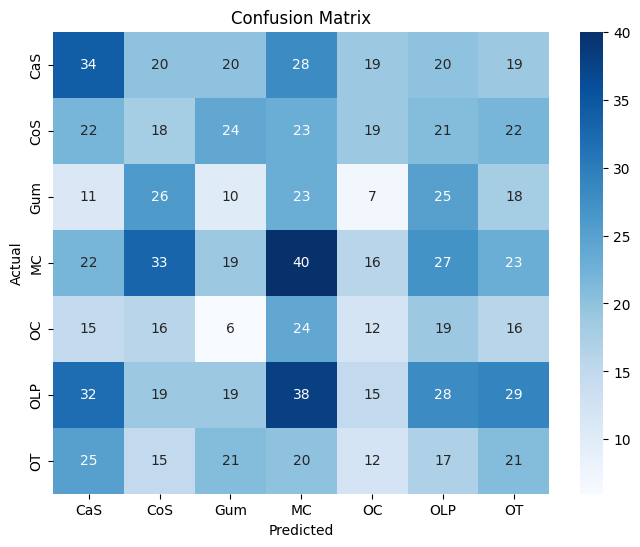

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
model.save('model.h5')

In [21]:
def load_trained_model():
    return load_model('model.h5')

In [22]:
def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array)
    return np.argmax(prediction)

In [23]:
st.title("Teeth Disease Classification Using InceptionResNetV2")
uploaded_file = st.file_uploader("Upload an image", type=["jpg", "png", "jpeg"])

2025-02-18 16:12:34.883 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-18 16:12:34.964 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-02-18 16:12:34.966 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-18 16:12:34.968 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-18 16:12:34.970 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-18 16:12:34.971 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-18 16:12:34.973 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-18 16:12:34.974 Thread 'MainThread': mi

In [24]:
if uploaded_file is not None:
    st.image(uploaded_file, caption='Uploaded Image', use_column_width=True)
    model = load_trained_model()
    prediction = predict_image(uploaded_file, model)
    st.write(f"Predicted Class: {list(test_generator.class_indices.keys())[prediction]}")